In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
from Bio import AlignIO
import time as time
import pandas as pd

In [2]:
starttime = time.time()

#Open data

data_path = '../../../data_RFAM/trnasim_100k_t1.hdf5'
with h5py.File(data_path, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])
    
numdata, seqlen, _, dims = X_data.shape
dims = dims-1

#remove gaps from sequences
ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]
    
# get validation and test set from training set
test_frac = 0.3
valid_frac = 0.1
N = numdata
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = int(N*(1-test_frac))
shuffle = np.random.permutation(N)

#set up dictionaries
train = {'inputs': X_data[shuffle[:split_1]], 
         'targets': Y_data[shuffle[:split_1]]}
valid = {'inputs': X_data[shuffle[split_1:split_2]], 
         'targets': Y_data[shuffle[split_1:split_2]]}
test = {'inputs': X_data[shuffle[split_2:]], 
         'targets': Y_data[shuffle[split_2:]]}
    
print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time()-starttime))

Data extraction and dict construction completed in: 13.23s


In [3]:
simalign_file = '../../../data_RFAM/trnasim_100k.sto'

#Get the full secondary structure from the emission
SS = mf.getSSconsensus(simalign_file)

#Get the ungapped sequence and the indices of ungapped nucleotides
_, ugSS, ugidx = mf.rm_consensus_gaps(X_data, SS)

#Get the sequence and indices of the conserved base pairs
bpchars = ['(',')','<','>','{','}']
sig_bpchars = ['<','>']
bpidx, bpSS, nonbpidx = mf.sigbasepair(SS, bpchars)
numbp = len(bpidx)

bpSS

'(((((((<<<<>>>><<<<<>>>>><<<<<>>>>>)))))))'

In [4]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    
    layer4 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                    # concat, embedding, variational_normal, variational_softmax, + more
          'num_units': 196,
          'norm': 'batch',          # if removed, automatically adds bias instead
          'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
          'dropout': 0.5,           # if removed, default is no dropout
             }

    
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../../../results/trna'
param_path = os.path.join(save_path, 'resbind')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 513, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: dense_0
(?, 196)
layer17: dense_0_batch
(?, 196)
layer18: dense_0_active
(?, 196)
layer19: dense_0_dropout
(?, 196)
layer20: den

In [5]:
# initialize session
sess = utils.initialize_session()

In [ ]:
#Train the model

data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=30, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

In [13]:
# initialize session
sess.close()
sess = utils.initialize_session()

In [6]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../../../results/trna/resbind_best.ckpt
INFO:tensorflow:Restoring parameters from ../../../results/trna/resbind_best.ckpt
  test  loss:		0.01174
  test  accuracy:	0.99970+/-0.00000
  test  auc-roc:	1.00000+/-0.00000
  test  auc-pr:		1.00000+/-0.00000


### First order saliency

/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


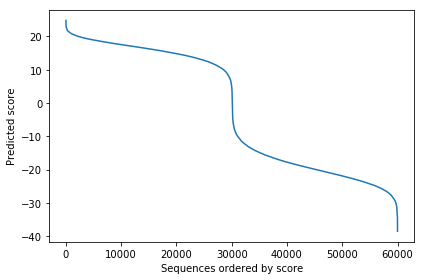

In [7]:
# sort activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='dense_1_bias')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

plt.figure()
plt.ylabel('Predicted score')
plt.xlabel('Sequences ordered by score')
plt.plot(range(len(plot_index)), predictionsoutput[plot_index])

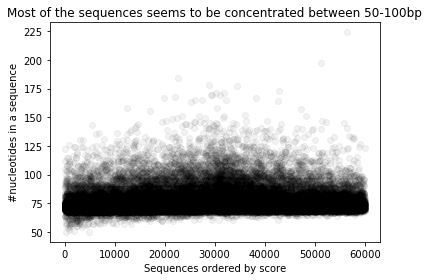

In [16]:
#Get the number of nucleotides of each sequence
numnucs = np.sum(test['inputs'][plot_index].reshape(int(test_frac*N), seqlen*dims), axis=1)

plt.figure()
plt.title('Most of the sequences seems to be concentrated between 50-100bp')
plt.ylabel('#nucleotides in a sequence')
plt.xlabel('Sequences ordered by score')
plt.scatter(range(len(plot_index)), numnucs, c='k', marker='o', alpha=0.05)

/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


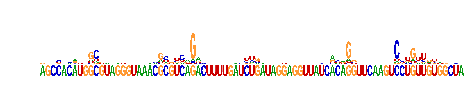

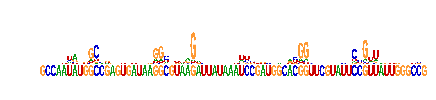

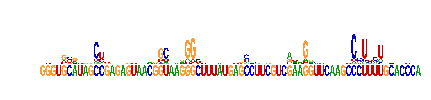

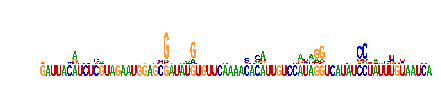

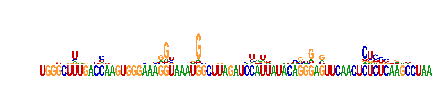

In [17]:
num_plots=np.linspace(0,20000,5).astype(int)
#num_plots = range(5)
for ii in num_plots: 

    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    mf.fom_saliency(X, layer='dense_1_bias', alphabet='rna', nntrainer=nntrainer, sess=sess, figsize=(15,1.5))
    

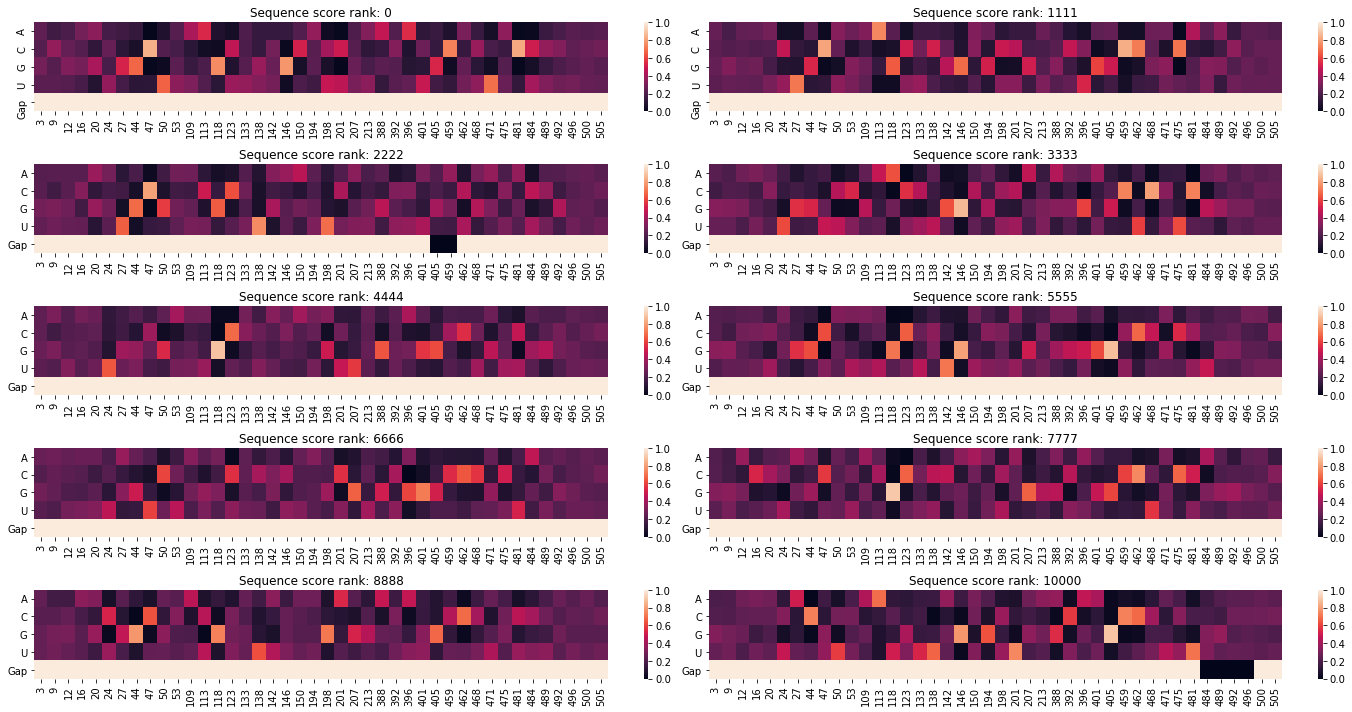

In [41]:
num_plots=np.linspace(0,10000,10).astype(int)
#num_plots = range(5)

fig =plt.figure(figsize=(20,10))

for sp, ii in enumerate(num_plots): 

    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    nuc_index = np.where(np.sum(X, axis=0)!=0)[0]
    
    norm_heat_mut = mf.fom_heatmap(X, layer='dense_1_bias', alphabet='rna', nntrainer=nntrainer, sess=sess, eps=1e-7)
    nucpos = np.zeros(shape=(1,seqlen))
    nucpos[:, nuc_index] = 1.
    norm_heat_mut = np.append(norm_heat_mut, nucpos, axis=0)
    
    
    ax = fig.add_subplot(5,2,sp+1)
    ax.set_title('Sequence score rank: %s' %ii)
    ax = sb.heatmap(norm_heat_mut[:, bpidx], vmin=0, vmax=1, cbar=True, 
                    yticklabels=['A', 'C', 'G', 'U', 'Gap'], xticklabels=bpidx)

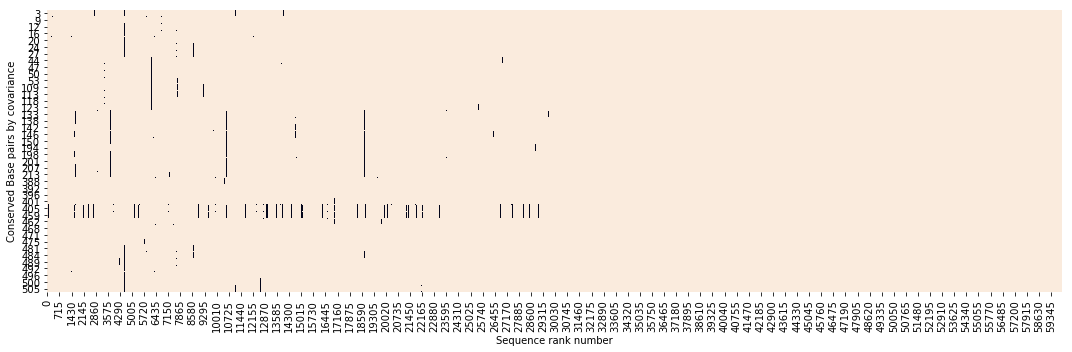

In [21]:
#num_plots=np.linspace(0,10000,10).astype(int)
num_plots = range(int(numdata*test_frac))
#for sp, ii in enumerate(num_plots): 
    
def nucpresence(Xdict, ii):
    X = np.expand_dims(Xdict['inputs'][plot_index[ii]], axis=0)
    nuc_index = np.where(np.sum(X, axis=0)!=0)[0]
    nucpos = np.zeros(shape=(1,seqlen))
    nucpos[:, nuc_index] = 1.
    return nucpos

nuc_sequences = [nucpresence(test,ii) for ii in num_plots]
    
plt.figure(figsize=(15,5))
sb.heatmap(np.squeeze(nuc_sequences)[:, bpidx].T, cbar=False, yticklabels=bpidx)
plt.ylabel('Conserved Base pairs by covariance')
plt.xlabel('Sequence rank number')


### Second Order Mutagenesis

In [23]:
def double_mutate_ungapped(X, ungapped_index):

    num_summary, seqlen, _, dims = X.shape
    idxlen = len(ungapped_index)

    mutations_matrix = np.zeros((idxlen,idxlen, dims*dims, seqlen,1,dims)) 

    for i1,position1 in enumerate(ungapped_index):

        for i2,position2 in enumerate(ungapped_index):

            for nuc1 in range(dims):

                for nuc2 in range(dims):

                    mut_seq = np.copy(X)
                    mut_seq[0, position1, 0, :] = np.zeros(dims)
                    mut_seq[0, position1, 0, nuc1] = 1.0
                    mut_seq[0, position2, 0, :] = np.zeros(dims)
                    mut_seq[0, position2, 0, nuc2] = 1.0

                    mutations_matrix[i1, i2, (nuc1*dims)+nuc2, :] = mut_seq

    return mutations_matrix

In [41]:
def som_average_ungapped(Xdict, ungapped_index, savepath, nntrainer, sess, progress='on', save=True, layer='output', 
                         normalize=False, normfactor=None, eps=0):

    num_summary, seqlen, _, dims = Xdict.shape

    starttime = time.time()

    idxlen = len(ungapped_index)

    sum_mut2_scores = np.zeros((idxlen*idxlen*dims*dims, 1))

    for ii in range(num_summary):
        if progress == 'on':
            print (ii)
        
        epoch_starttime = time.time()
        
        #extract sequence
        X = np.expand_dims(Xdict[ii], axis=0)

        X_mutsecorder = double_mutate_ungapped(X, ungapped_index)

        #reshape the 6D tensor into a 4D tensor that the model can test
        X_mutsecorder_reshape = np.reshape(X_mutsecorder, (idxlen*idxlen*dims*dims, seqlen, 1, dims))
        mutations = {'inputs': X_mutsecorder_reshape, 'targets': np.ones((X_mutsecorder_reshape.shape[0], 1))}

        #Get output activations for the mutations
        mut2_scores= nntrainer.get_activations(sess, mutations, layer=layer)

        if normalize:
            #take the WT and put it into a dict for deepomics
            WT = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
            #Get output or logits activations for the WT sequence
            predictions = nntrainer.get_activations(sess, WT, layer=layer)
            
            #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
            mut2_scores = mut2_scores - predictions[0] + eps
            mut2_scores = normalize_hol(mut2_scores, factor=normfactor)

        #Sum all the scores into a single matrix
        sum_mut2_scores += mut2_scores

        epoch_endtime = time.time()
        
        if progress == 'on':

            print ('Epoch duration =' + mf.sectotime(epoch_endtime -epoch_starttime))
            print ('Cumulative duration =' + mf.sectotime(epoch_endtime - starttime))
            print ()
            
    if progress == 'off':
        print ('----------------Summing complete----------------')
        
    # Save the summed array for future use
    if save == True:
        np.save(savepath, sum_mut2_scores)
        print ('Saving scores to ' + savepath)

    return (sum_mut2_scores)


In [66]:
savepath = 'Arrays/trna_resbindt1_so500.npy'

num_summary = 500
Xdict = test['inputs'][plot_index[:num_summary]]

sum_mut2 = som_average_ungapped(Xdict, ungapped_index=bpidx, savepath=savepath, nntrainer=nntrainer, 
                                sess=sess, progress='on', save=True, layer='dense_1_bias', 
                               normalize=False, normfactor=0)

0
Epoch duration =0.71s
Cumulative duration =0.71s

1
Epoch duration =0.7s
Cumulative duration =1.41s

2
Epoch duration =0.7s
Cumulative duration =2.11s

3
Epoch duration =0.7s
Cumulative duration =2.8s

4
Epoch duration =0.71s
Cumulative duration =3.52s

5
Epoch duration =0.71s
Cumulative duration =4.23s

6
Epoch duration =0.7s
Cumulative duration =4.93s

7
Epoch duration =0.7s
Cumulative duration =5.64s

8
Epoch duration =0.79s
Cumulative duration =6.42s

9
Epoch duration =0.88s
Cumulative duration =7.31s

10
Epoch duration =0.92s
Cumulative duration =8.23s

11
Epoch duration =0.7s
Cumulative duration =8.93s

12
Epoch duration =0.72s
Cumulative duration =9.65s

13
Epoch duration =0.7s
Cumulative duration =10.35s

14
Epoch duration =0.69s
Cumulative duration =11.04s

15
Epoch duration =0.69s
Cumulative duration =11.74s

16
Epoch duration =0.7s
Cumulative duration =12.44s

17
Epoch duration =0.7s
Cumulative duration =13.13s

18
Epoch duration =0.7s
Cumulative duration =13.84s

19
Epoch

In [8]:
#load values
savepath = 'Arrays/trna_resbindt1_so500.npy'
sum_mut2 = np.load(savepath)

#average the values
num_summary = 500
mean_mut2 = sum_mut2/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4 matrices
meanhol_mut2 = mean_mut2.reshape(numbp,numbp,dims,dims)

In [9]:
def normalize_hol(hol, factor=None):

    MAX = np.max(np.abs(hol))
    hol = hol/MAX
    if factor:
        hol = np.exp(hol*factor)
    norm = np.sum(np.abs(hol))
    return (hol/norm)

In [11]:
#normalize the holistic mutation scores
WT_mean = np.mean(nntrainer.get_activations(sess, test, layer='dense_1_bias')[plot_index[:500]])

norm_meanhol_mut2 = np.copy(meanhol_mut2) - WT_mean
for one in range(len(bpidx)):
        for two in range(len(bpidx)):
            norm_meanhol_mut2[one, two] = normalize_hol(meanhol_mut2[one, two], factor=None)



In [31]:
meanhol_mut2.shape

(42, 42, 4, 4)

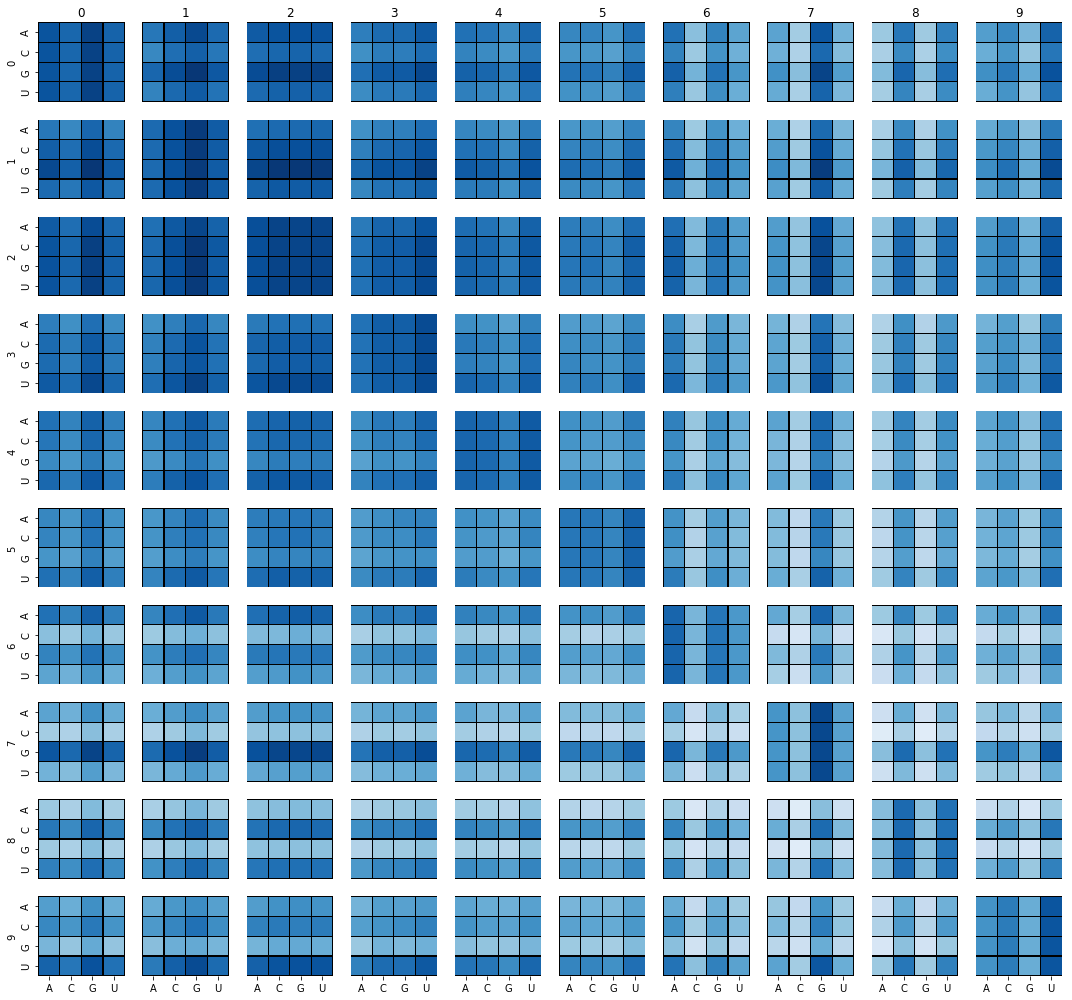

In [45]:
mf.square_holplot(meanhol_mut2, num=10, alphabet='rna', start=(0, 0), title=True, 
                 limits = (np.min(meanhol_mut2), np.max(meanhol_mut2)))

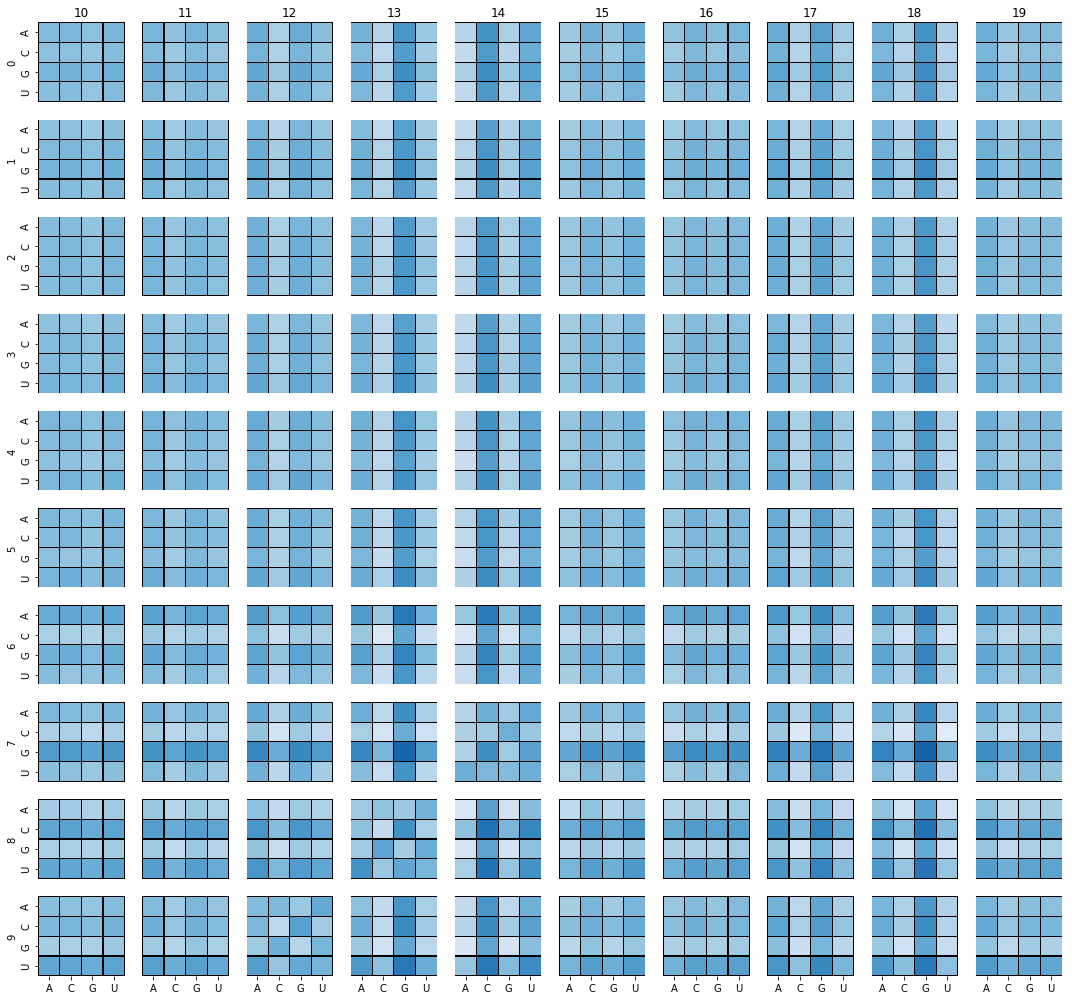

In [103]:
mf.square_holplot(norm_meanhol_mut2, num=10, alphabet='rna', start=(0, 10), title=True, 
                 limits = (np.min(norm_meanhol_mut2), np.max(norm_meanhol_mut2)))

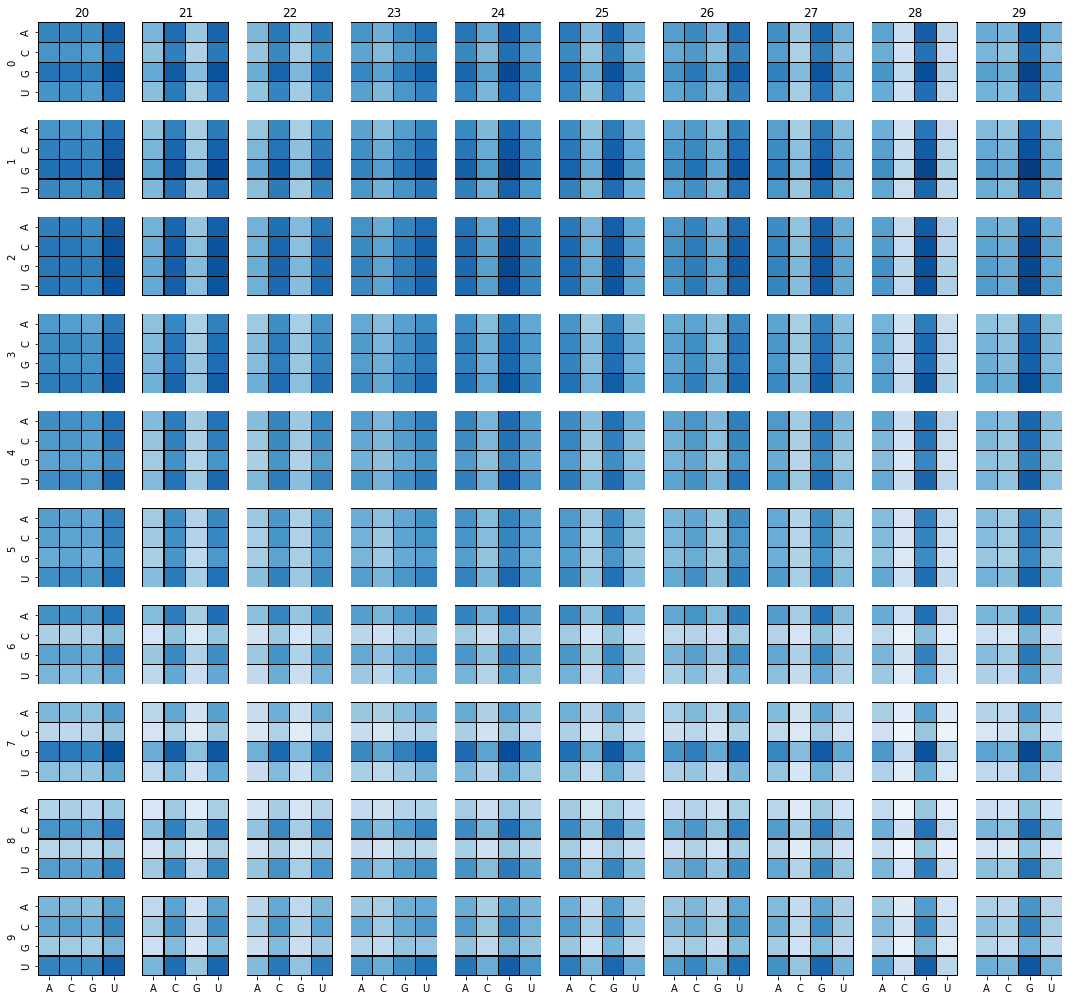

In [47]:
mf.square_holplot(meanhol_mut2, num=10, alphabet='rna', start=(0, 20), title=True, 
                 limits = (np.min(meanhol_mut2), np.max(meanhol_mut2)))

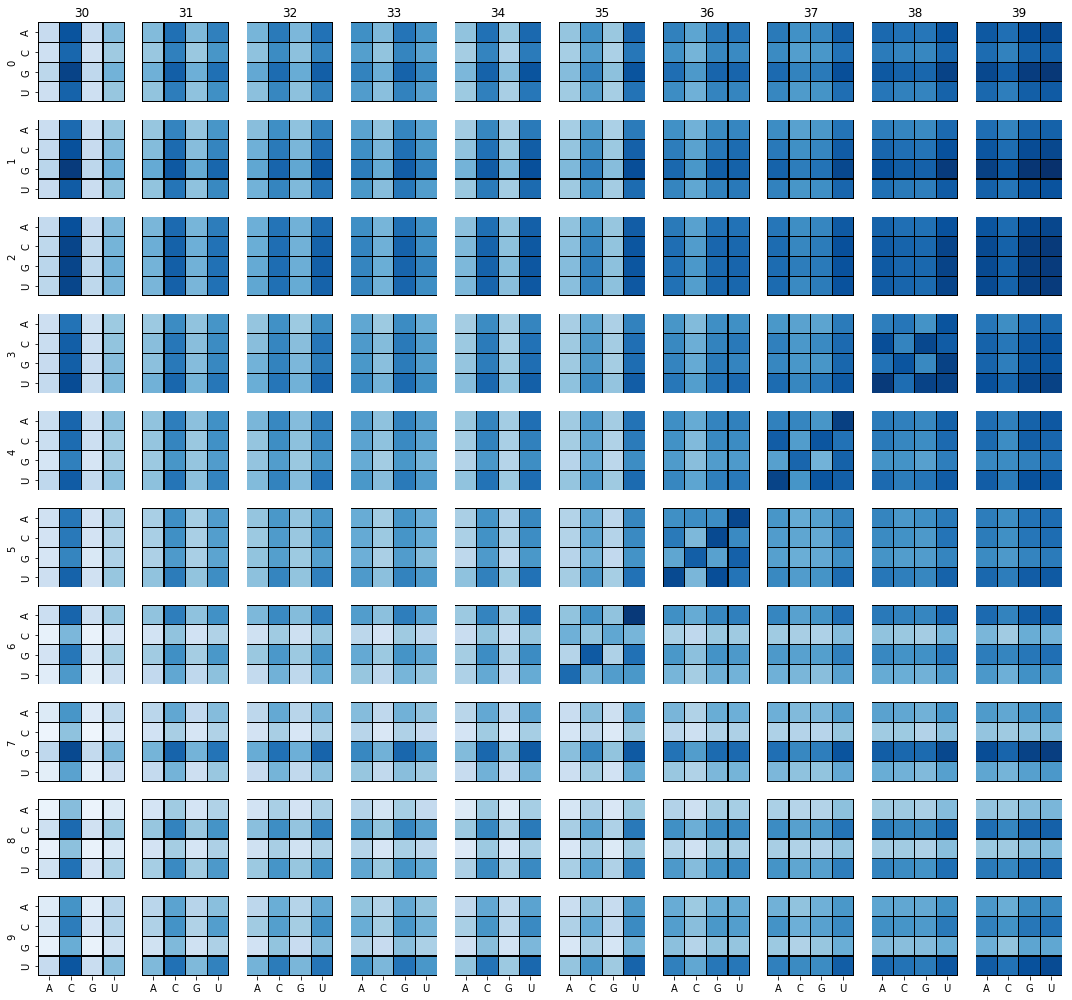

In [48]:
mf.square_holplot(meanhol_mut2, num=10, alphabet='rna', start=(0, 30), title=True, 
                 limits = (np.min(meanhol_mut2), np.max(meanhol_mut2)))

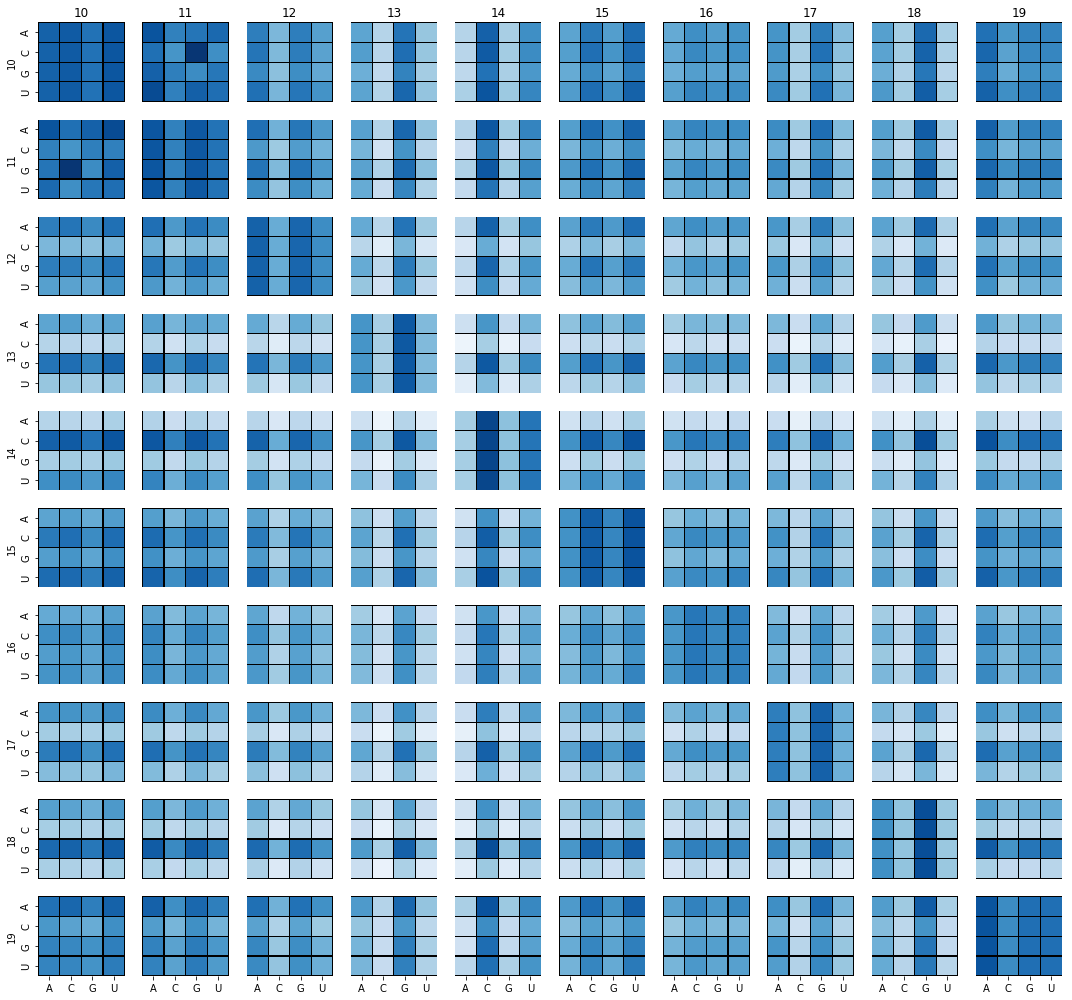

In [49]:
mf.square_holplot(meanhol_mut2, num=10, alphabet='rna', start=(10, 10), title=True, 
                 limits = (np.min(meanhol_mut2), np.max(meanhol_mut2)))

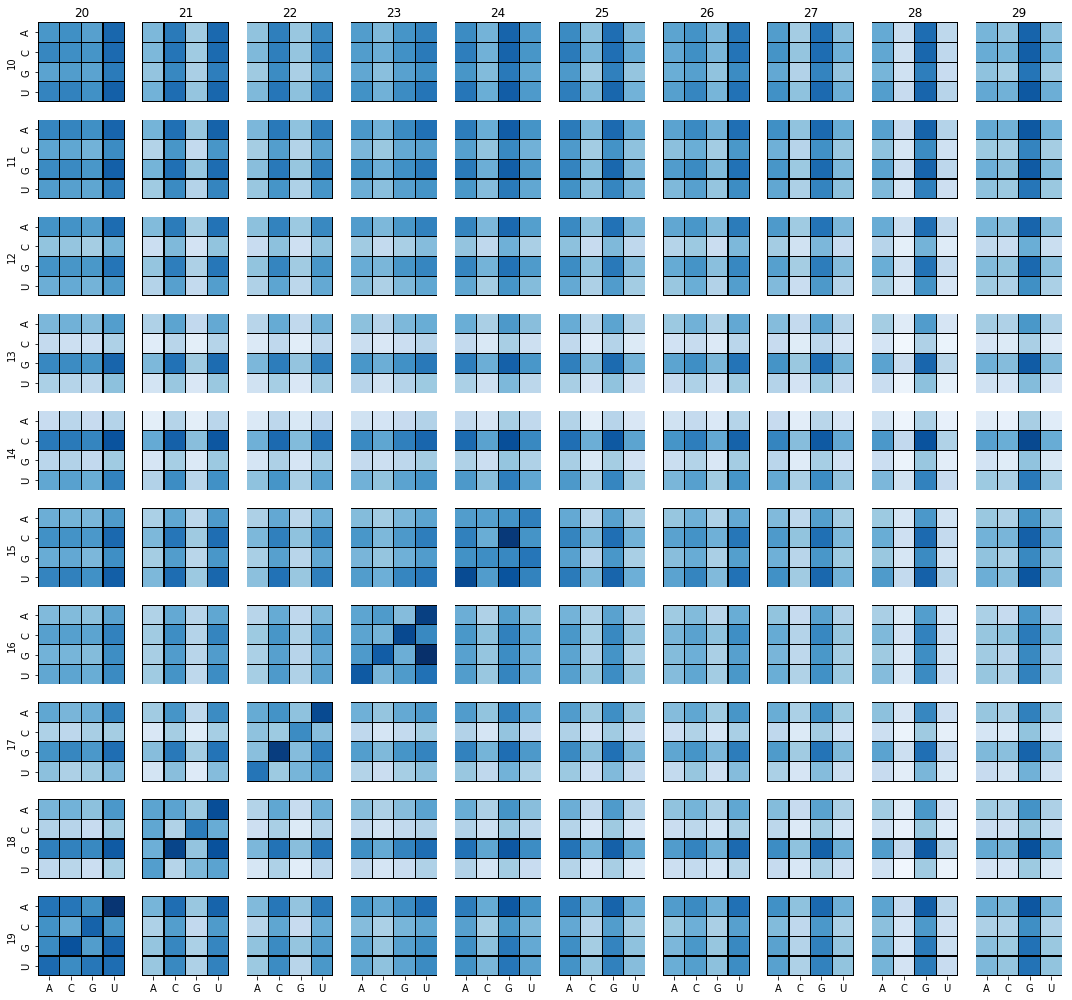

In [50]:
mf.square_holplot(meanhol_mut2, num=10, alphabet='rna', start=(10, 20), title=True, 
                 limits = (np.min(meanhol_mut2), np.max(meanhol_mut2)))

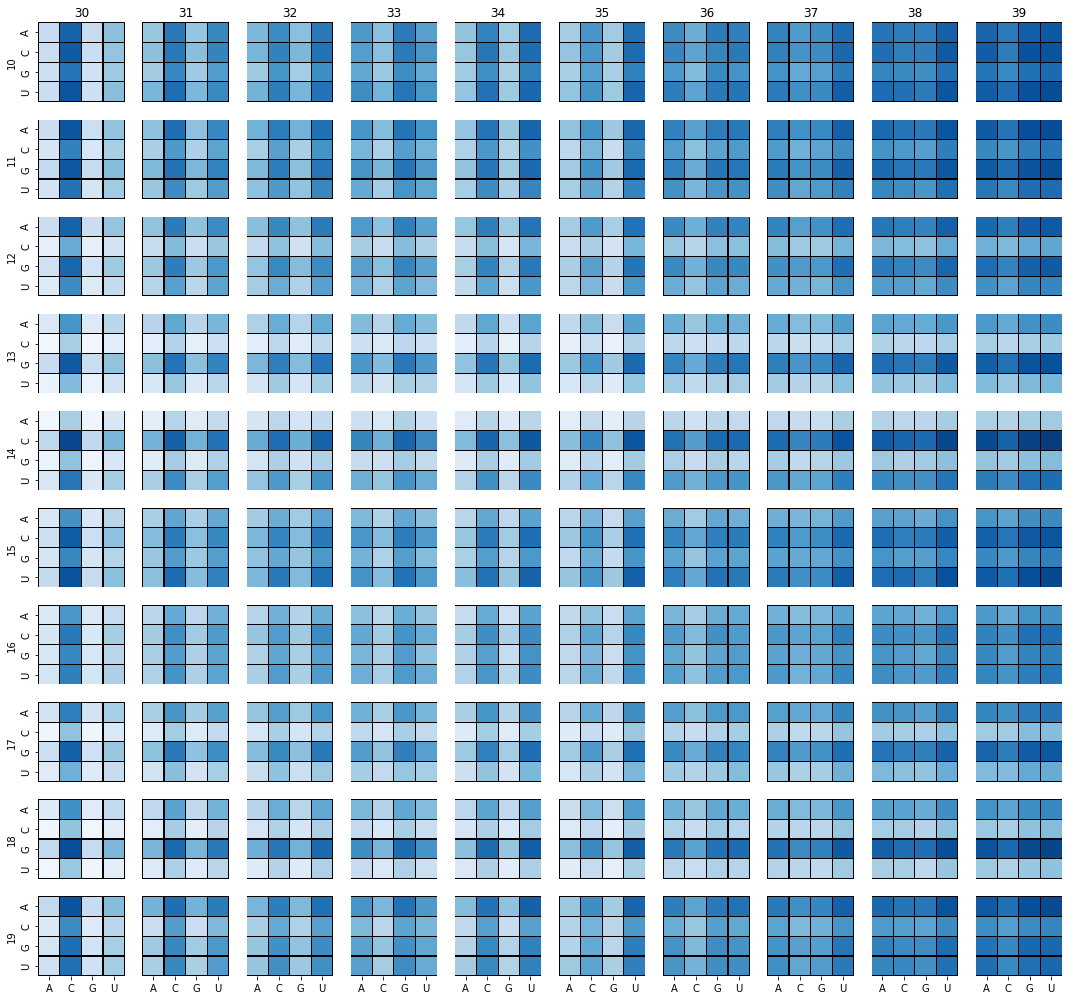

In [51]:
mf.square_holplot(meanhol_mut2, num=10, alphabet='rna', start=(10, 30), title=True, 
                 limits = (np.min(meanhol_mut2), np.max(meanhol_mut2)))

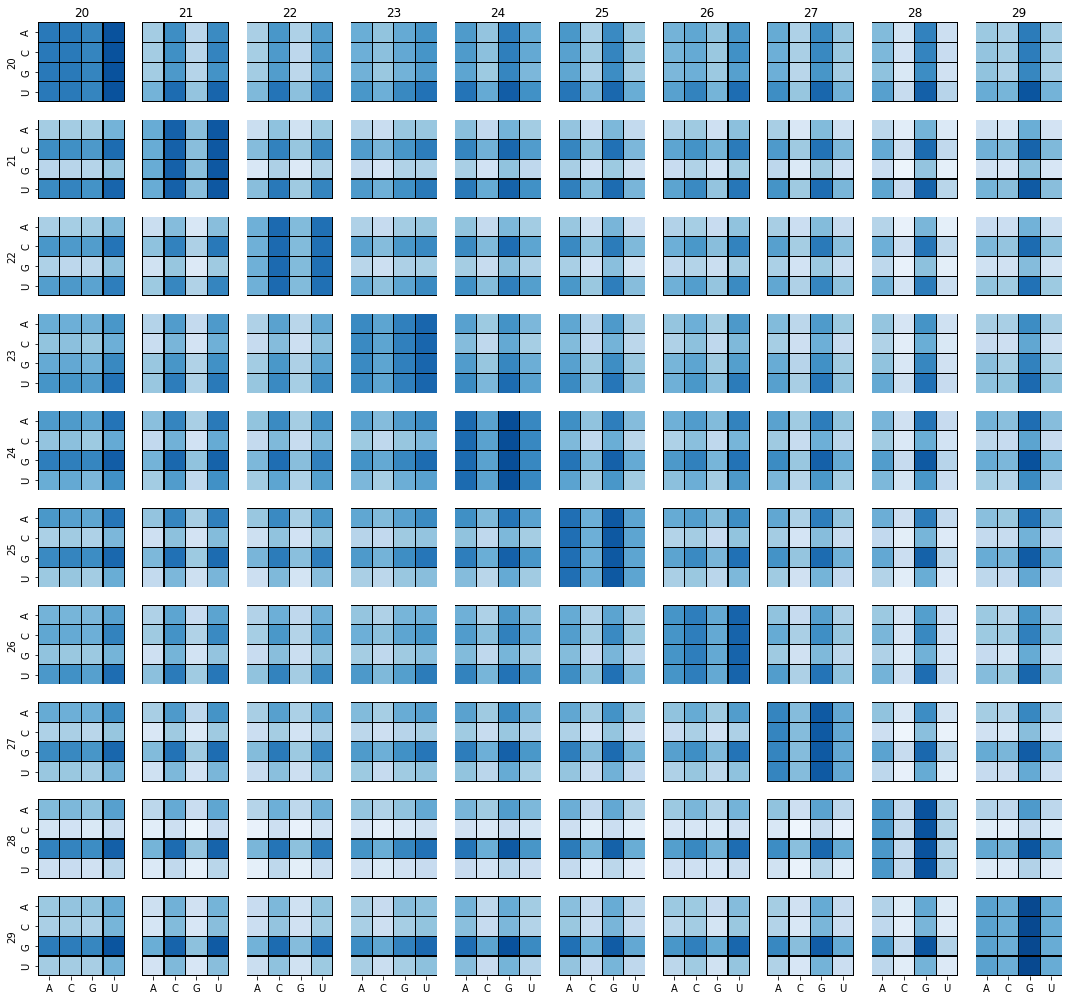

In [52]:
mf.square_holplot(meanhol_mut2, num=10, alphabet='rna', start=(20, 20), title=True, 
                 limits = (np.min(meanhol_mut2), np.max(meanhol_mut2)))

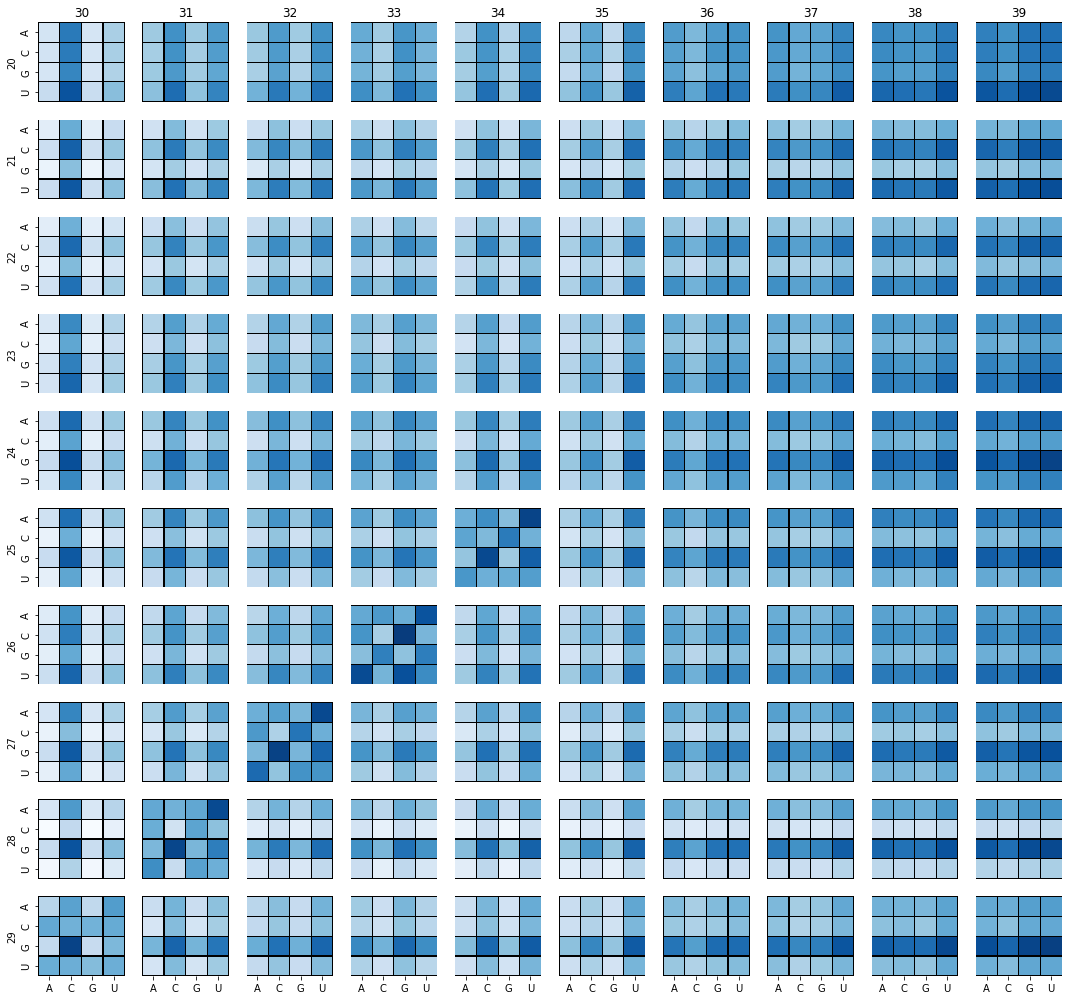

In [53]:
mf.square_holplot(meanhol_mut2, num=10, alphabet='rna', start=(20, 30), title=True, 
                 limits = (np.min(meanhol_mut2), np.max(meanhol_mut2)))

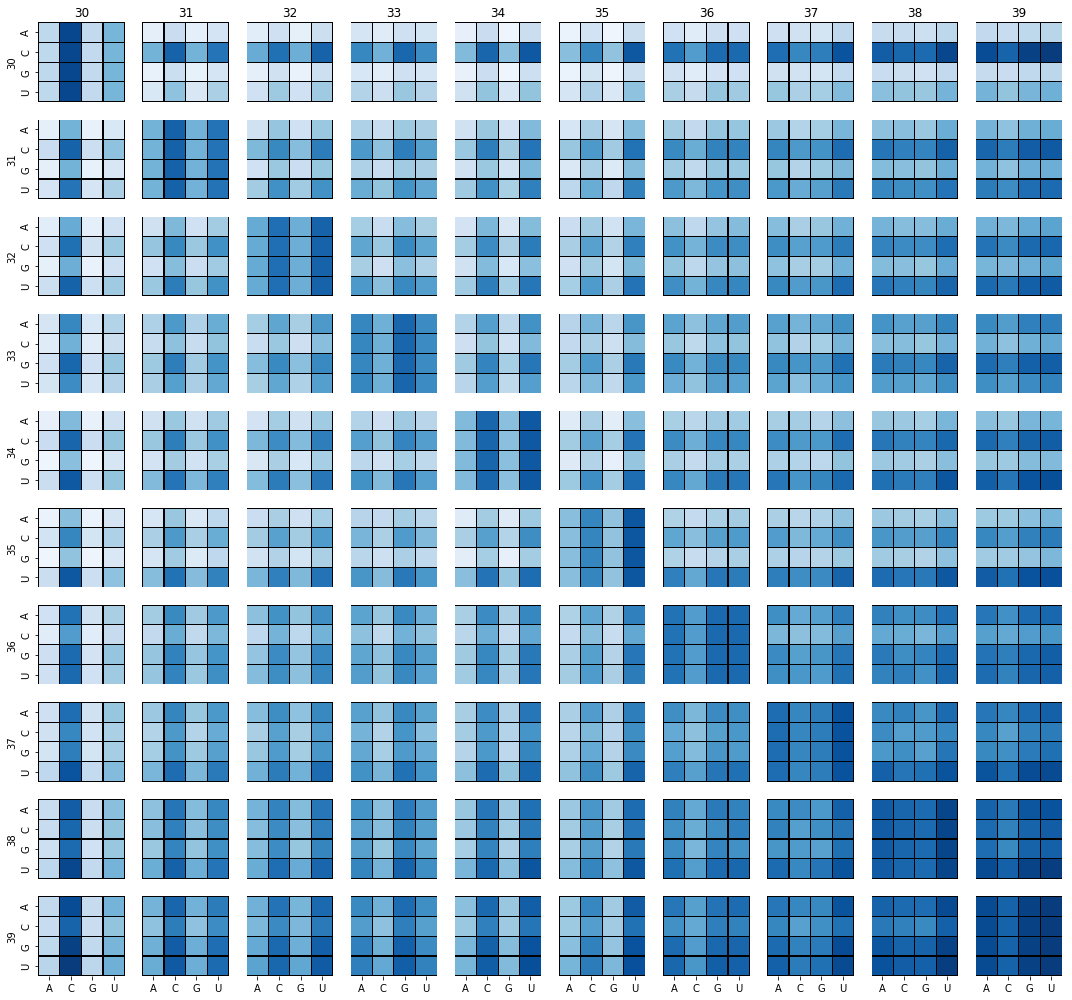

In [54]:
mf.square_holplot(meanhol_mut2, num=10, alphabet='rna', start=(30, 30), title=True, 
                 limits = (np.min(meanhol_mut2), np.max(meanhol_mut2)))

<function matplotlib.pyplot.show>

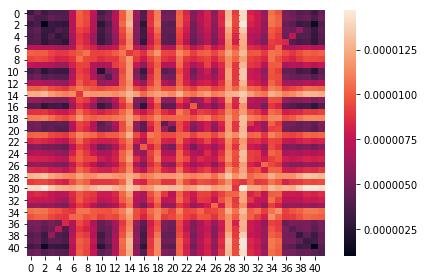

In [60]:
plt.figure()
sb.heatmap(np.std(meanhol_mut2.reshape(len(bpidx),len(bpidx),dims*dims), axis=2))
plt.show

<function matplotlib.pyplot.show>

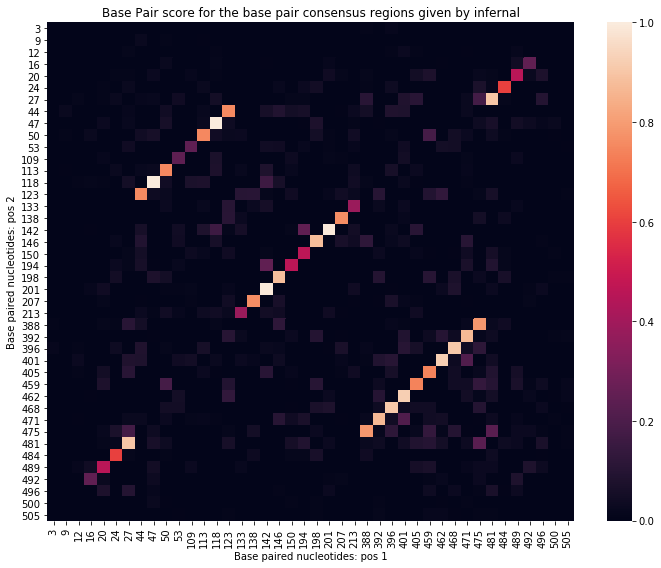

In [13]:
#Let's try something weird
bpfilter = np.ones((4,4))*-1
for i,j in zip(range(4), range(4)):
    bpfilter[i, -(j+1)] = 1.
    
C = np.sum((norm_meanhol_mut2*bpfilter).reshape(len(bpidx),len(bpidx),dims*dims), axis=2)
C = C - np.mean(C)
C = C/np.max(C)

plt.figure(figsize=(10,8))
sb.heatmap(C, xticklabels=bpidx, yticklabels=bpidx, vmin=0.)
plt.title('Base Pair score for the base pair consensus regions given by infernal')
plt.xlabel('Base paired nucleotides: pos 1')
plt.ylabel('Base paired nucleotides: pos 2')
plt.show

In [14]:
#Let's try something weird
import itertools as it
bptypes = list(it.product([1,-1], repeat=4))
bpfilters = np.ones((len(bptypes), 4, 4))*-1
for f, tt in enumerate(bptypes):
    for i in range(4):
        bpfilters[f, i, -(i+1)] = tt[i]
    


<function matplotlib.pyplot.show>

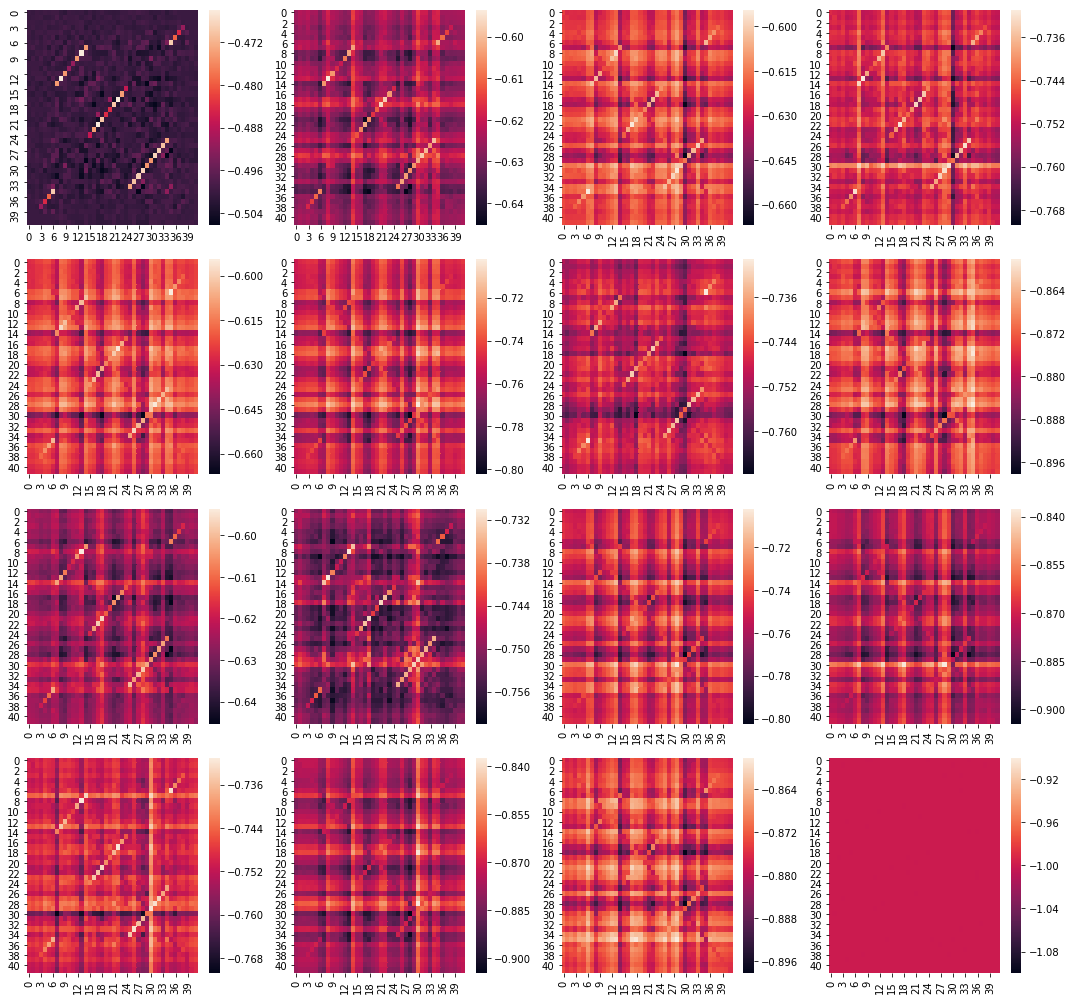

In [15]:
fig = plt.figure(figsize=(15,14))
for p in range(len(bptypes)):
    ax = fig.add_subplot(4,4,p+1)
    C = np.sum((norm_meanhol_mut2*bpfilters[p]).reshape(len(bpidx),len(bpidx),dims*dims), axis=2)
    ax = sb.heatmap(C)
plt.show

<function matplotlib.pyplot.show>

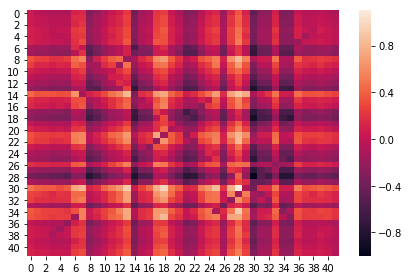

In [41]:
filteredmean = [np.sum((norm_meanhol_mut2*bpfilters[p]).reshape(len(bpidx),len(bpidx),dims*dims), axis=2) 
                for p in [0,5,10]]

norm = []
for C in filteredmean:
    C = C - np.mean(C)
    C = C/np.max(C)
    norm.append(C)


plt.figure()
sb.heatmap(norm[0]-norm[1]-norm[0])
plt.show

In [29]:
np.shape(filteredmean)

(3, 42, 42)

<function matplotlib.pyplot.show>

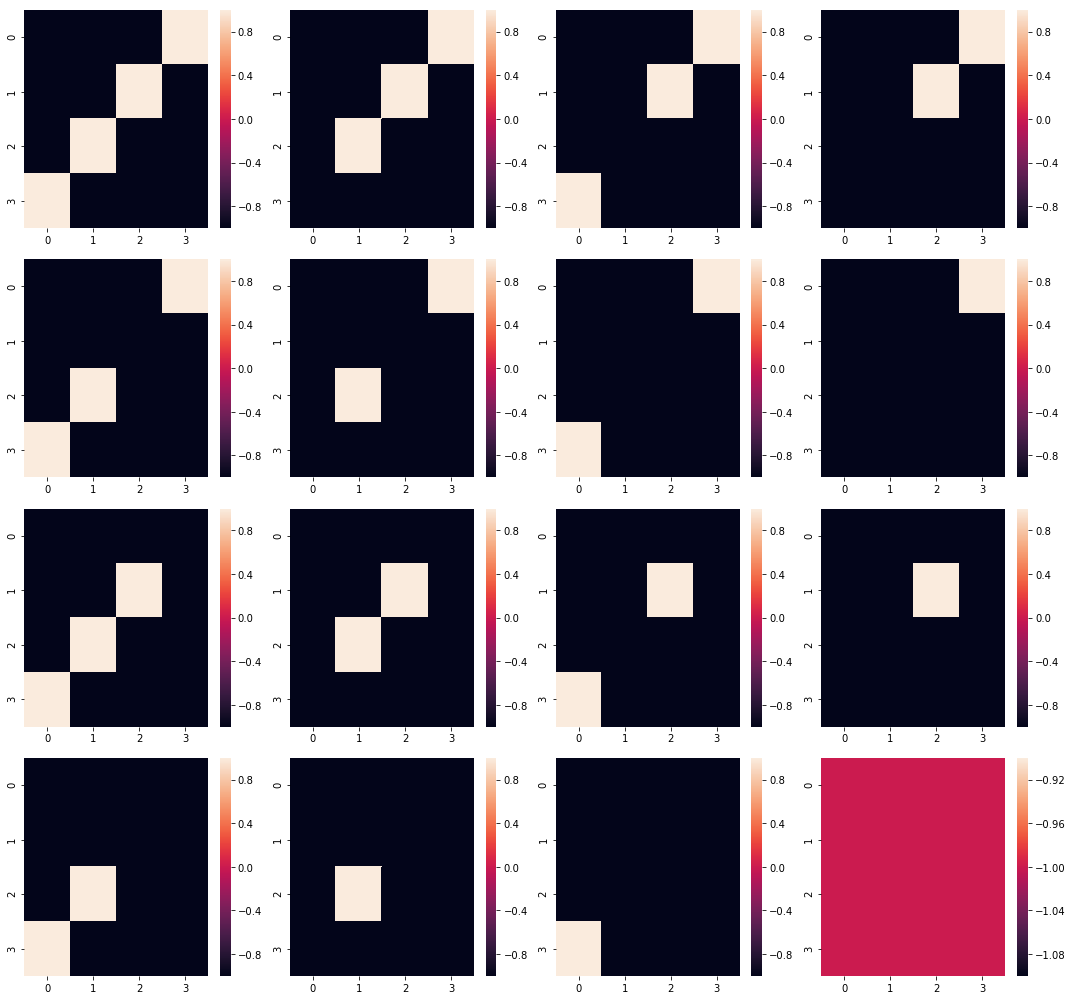

In [126]:
fig = plt.figure(figsize=(15,14))
for p in range(len(bptypes)):
    ax = fig.add_subplot(4,4,p+1)
    ax = sb.heatmap(bpfilters[p])
plt.show

In [128]:
sess.close()